In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import stats
import random
from scipy.stats import sem
from sklearn.feature_selection import SelectKBest, mutual_info_regression


In [9]:
main_path= "D:/Year 4/HONS/Auto_QA_gestures/"
jerks_path = main_path + "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path =main_path +  "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path =main_path +  "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path =main_path +  "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path =main_path +  "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

spectral_properties_path =main_path +  "Dataset/Appropriateness_Features/Mean_Spectral_Centroid_over_time.csv"
XX_spectral_properties = pd.read_csv(spectral_properties_path, index_col = False) 
print(XX_spectral_properties.columns)

msc_props_path = main_path + "Dataset/Appropriateness_Features/Mean_Spectral_Centroid_props.csv"
XX_msc_properties = pd.read_csv(msc_props_path, index_col = False)

mfcc_path =main_path +  "Dataset/Appropriateness_Features/Mean_MFCC_over_time.csv"
XX_mfcc = pd.read_csv(mfcc_path, index_col = False)

msc_distance_path = main_path + "Dataset/Appropriateness_Features/MSC_Distance_scores_fd_scaled.csv"
XX_msc_distance_scores = pd.read_csv(msc_distance_path, index_col = False)

msbw_distance_path = main_path + "Dataset/Appropriateness_Features/MSBW_Distance_scores_fd_scaled.csv"
XX_msbw_distance_scores = pd.read_csv(msbw_distance_path, index_col = False)

labels_path = main_path + "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"
print(YY.columns)

Index(['Unnamed: 0', 'StudySeq', 'Mean_Spectral_Centroid1',
       'Mean_Spectral_Centroid2', 'Mean_Spectral_Centroid3',
       'Mean_Spectral_Centroid4', 'Mean_Spectral_Centroid5',
       'Mean_Spectral_Centroid6', 'Mean_Spectral_Centroid7',
       'Mean_Spectral_Centroid8', 'Mean_Spectral_Centroid9',
       'Mean_Spectral_Centroid10'],
      dtype='object')
Index(['Unnamed: 0', 'Mean_Appropriateness_Score'], dtype='object')


In [10]:
# Merging the features
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -5:] = XX_rms_energy_properties
# join the spectral properties
#find overlapping columns between XY and XX_spectral_properties
XY = XY.join(XX_spectral_properties, rsuffix='_spectral')
#duplicate the spectral properties for each study sequence 
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -12:] = XX_spectral_properties

    
XY = XY.join(XX_msc_properties, rsuffix='_msc')
#duplicate the mfcc features for each study sequence
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -5:] = XX_msc_properties
    
XY = XY.join(XX_msc_distance_scores, rsuffix='_msc_dist')

XY = XY.join(XX_msbw_distance_scores, rsuffix='_msbw_dist')


# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['Unnamed: 0_YY', 'Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
         'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms','StudySeq_msc' , 'Unnamed: 0_msc', 'Unnamed: 0_spectral', 'StudySeq_spectral', 'Unnamed: 0_msc_dist' , 'Unnamed: 0_msbw_dist'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

XY = XY.drop(['StudySeq_jerks'], axis=1, inplace=False)
# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
#print row 35 to 45

for col in XX.columns:
    print(col)

Spine1_jerks
Spine2_jerks
Spine3_jerks
LeftShoulder_jerks
LeftArm_jerks
LeftForearm_jerks
LeftHand_jerks
RightShoulder_jerks
RightArm_jerks
RightForearm_jerks
RightHand_jerks
Neck_jerks
Neck1_jerks
Head
Spine1_accels
Spine2_accels
Spine3_accels
LeftShoulder_accels
LeftArm_accels
LeftForearm_accels
LeftHand_accels
RightShoulder_accels
RightArm_accels
RightForearm_accels
RightHand_accels
Neck_accels
Neck1_accels
Head_accels
Spine1_vs_Spine2
Spine1_vs_Spine3
Spine1_vs_LeftShoulder
Spine1_vs_LeftArm
Spine1_vs_LeftForeArm
Spine1_vs_LeftHand
Spine1_vs_RightShoulder
Spine1_vs_RightArm
Spine1_vs_RightForeArm
Spine1_vs_RightHand
Spine1_vs_Neck
Spine1_vs_Neck1
Spine1_vs_Head
Spine2_vs_Spine3
Spine2_vs_LeftShoulder
Spine2_vs_LeftArm
Spine2_vs_LeftForeArm
Spine2_vs_LeftHand
Spine2_vs_RightShoulder
Spine2_vs_RightArm
Spine2_vs_RightForeArm
Spine2_vs_RightHand
Spine2_vs_Neck
Spine2_vs_Neck1
Spine2_vs_Head
Spine3_vs_LeftShoulder
Spine3_vs_LeftArm
Spine3_vs_LeftForeArm
Spine3_vs_LeftHand
Spine3_vs_Rig

In [11]:
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Appropriateness_Score']
for i in range(1,11):
    XX[f'Mean_Spectral_Centroid{i}'] = pd.to_numeric(XX[f'Mean_Spectral_Centroid{i}'], errors='coerce')
    #find data type of Mean spectral centroid column
    print(XX[f'Mean_Spectral_Centroid{i}'].head())
numeric_columns = XX.select_dtypes(include=[np.number]).columns.tolist()
print(numeric_columns)
#do log scaling of all features
# XX = np.log(XX)
XX.iloc[:,-17:-3] = XX.iloc[:,-17:-3]
print(XX.shape)
print(YY.shape)
print(XX.head())

0    1581.553631
1    1886.272151
2    1992.480506
3    2077.878866
4    1767.230737
Name: Mean_Spectral_Centroid1, dtype: float64
0    1856.858500
1    1176.060631
2    2013.262526
3    2042.350654
4    1845.739558
Name: Mean_Spectral_Centroid2, dtype: float64
0    1613.227132
1    1455.218458
2    2005.625374
3    1507.400860
4    2154.118340
Name: Mean_Spectral_Centroid3, dtype: float64
0    1847.308838
1    1238.302652
2    2363.009487
3    1538.073381
4    2054.317002
Name: Mean_Spectral_Centroid4, dtype: float64
0    1906.900318
1    1878.034121
2    2834.440471
3    2116.445918
4    1172.974369
Name: Mean_Spectral_Centroid5, dtype: float64
0    1987.519331
1    2287.425252
2    1789.121860
3    2084.355579
4    1225.704655
Name: Mean_Spectral_Centroid6, dtype: float64
0    1799.152636
1    1794.904255
2    2111.369344
3    1844.902965
4    1710.545890
Name: Mean_Spectral_Centroid7, dtype: float64
0    1522.074641
1    2475.311124
2    1242.542542
3    2050.473720
4    2067.76590

In [12]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.2, random_state=42)

In [30]:
XX_train.shape

(288, 173)

In [7]:
input_dim = 173
output_dim = 1
model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(output_dim, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
model.fit(XX_train, YY_train, epochs=200, batch_size=10, validation_data=(XX_test, YY_test), verbose=2)   

Epoch 1/200
29/29 - 1s - loss: 32000.9766 - val_loss: 1512.0607 - 1s/epoch - 38ms/step
Epoch 2/200
29/29 - 0s - loss: 756.5748 - val_loss: 453.5019 - 53ms/epoch - 2ms/step
Epoch 3/200
29/29 - 0s - loss: 386.7557 - val_loss: 422.7378 - 53ms/epoch - 2ms/step
Epoch 4/200
29/29 - 0s - loss: 393.9750 - val_loss: 341.7090 - 57ms/epoch - 2ms/step
Epoch 5/200
29/29 - 0s - loss: 244.8924 - val_loss: 313.5538 - 57ms/epoch - 2ms/step
Epoch 6/200
29/29 - 0s - loss: 296.2032 - val_loss: 297.3375 - 58ms/epoch - 2ms/step
Epoch 7/200
29/29 - 0s - loss: 469.3292 - val_loss: 473.1488 - 56ms/epoch - 2ms/step
Epoch 8/200
29/29 - 0s - loss: 291.0316 - val_loss: 432.9145 - 57ms/epoch - 2ms/step
Epoch 9/200
29/29 - 0s - loss: 219.0622 - val_loss: 250.3200 - 56ms/epoch - 2ms/step
Epoch 10/200
29/29 - 0s - loss: 165.1515 - val_loss: 329.0056 - 57ms/epoch - 2ms/step
Epoch 11/200
29/29 - 0s - loss: 163.1596 - val_loss: 309.8263 - 54ms/epoch - 2ms/step
Epoch 12/200
29/29 - 0s - loss: 175.1664 - val_loss: 255.9476

In [13]:
def validation_curve(model, XX, YY, param_grid, log_bool, extra_string, xticks, x_vals, xlabel):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
        
        cv_model.fit(XX_train, YY_train, epochs=250, batch_size=288, verbose=False, shuffle=True, callbacks = [callback])
        
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    plt.figure(figsize = (6,4))
    plt.plot(x_vals, mean_train_mse, label='Training Set MSE')
    plt.fill_between(x_vals, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(x_vals, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(x_vals, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(xticks),max(xticks))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(xlabel)
    plt.title('ANN performance on varying ' + extra_string)
    plt.legend()
    
    print('Best Param: ', x_vals[np.where(mean_val_mse == min(mean_val_mse))])
    

In [14]:
def predicted_vs_true(model, XX, YY, epochs, validation_split, batch_size, callback):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    model.save_weights('initial_app.h5')
    for train, test in folds:
        model.load_weights('initial_app.h5')
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train, epochs=epochs, validation_split=validation_split,
                  batch_size=batch_size, verbose = 0, callbacks = [callback])
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test).flatten()
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of ANN on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

In [15]:
def create_ann(neurons_grid):
    input_dim = 173
    output_dim = 1
    
    model = Sequential()
    model.add(Dense(neurons_grid[0], input_dim=input_dim, activation='relu'))
    
    for layer in neurons_grid[1:]:
        model.add(Dense(layer, activation='relu'))
        
    model.add(Dense(output_dim))
    
    model.compile(optimizer = 'adam', loss='mse')
    
    return model

In [16]:
def create_neuron_grid(neurons_per_layer, layer_cap):
    neuron_grid = []
    for i in range(1,layer_cap+1):
        neuron_grid = neuron_grid + [[neurons_per_layer]*i]
    return neuron_grid

In [17]:
def reduce_by_fs_score(XX, YY, threshold):
    scores = mutual_info_regression(XX, YY, discrete_features = False)
    reduced_XX = XX.drop(XX.columns[np.where(scores < threshold)], axis=1, inplace=False)
    return reduced_XX

In [18]:
def feature_curve(XX, YY, param_grid, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        val_scores = []
        train_scores = []
        for threshold in param_grid:
            reduced_XX_train = reduce_by_fs_score(XX_train, YY_train, threshold)
            
            model = Sequential()
            model.add(Dense(14, input_dim=len(reduced_XX_train.columns), activation='relu')) # hidden layer 1
            model.add(Dense(14)) #2 
            model.add(Dense(14)) #3 
            model.add(Dense(14)) #4 
            model.add(Dense(14)) #5 
            model.add(Dense(14)) #6
            model.add(Dense(1))
            model.add(Dense(1))
            model.compile(optimizer = 'adam', loss='mse')
            
            callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
            
            history = model.fit(reduced_XX_train, YY_train, epochs=250, validation_split=0.2, batch_size=288, verbose = 0, 
                 callbacks = [callback])

            
            val_scores = val_scores + [history.history['val_loss'][history.history['loss'].index(min(history.history['loss']))]]
            train_scores = train_scores + [min(history.history['loss'])]

        outer_val_mse = outer_val_mse + [val_scores]
        outer_train_mse = outer_train_mse + [train_scores]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    
    plt.figure(figsize=(6,4))
    plt.plot(param_grid, mean_train_mse, label='MSE on Training Set')
    plt.plot(param_grid, mean_val_mse, label='MSE on Validation Set')
    plt.xlim(min(param_grid), max(param_grid))
    plt.xticks(xticks)
    plt.ylim(0, max(mean_val_mse) + max(mean_val_mse)*0.05)
    plt.ylabel('MSE')
    plt.xlabel('Mutual Information Score Threshold')
    plt.title('ANN performance on varying Mutual Information Score Threshold')
    plt.legend()
    
    print('Best Mutual Information Score Threshold: ', param_grid[np.where(mean_val_mse == (min(mean_val_mse)))[0]])

3/3 [==============================] - 0s 3ms/step
Fold  1 / 5  Complete.
3/3 [==============================] - 0s 2ms/step
Fold  2 / 5  Complete.
3/3 [==============================] - 0s 3ms/step
Fold  3 / 5  Complete.
3/3 [==============================] - 0s 3ms/step
Fold  4 / 5  Complete.
3/3 [==============================] - 0s 2ms/step
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.558929419856988
Test Mean Squared Error =  127.99130955918766
Train Mean Squared Error =  119.02522277365816
Time taken:  14.183347463607788


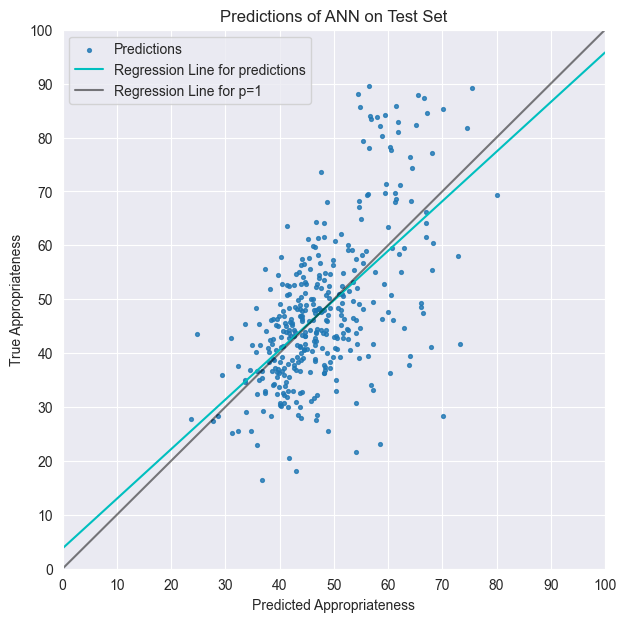

In [45]:
start_time = time.time()
model.add(Dense(256, input_dim=173, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer = 'adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
predicted_vs_true(model, XX, YY, 2000, 0, 144, callback)
print("Time taken: ", time.time() - start_time)